#### 参数估计 

In [35]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=50)

# 深度学习的三个步骤

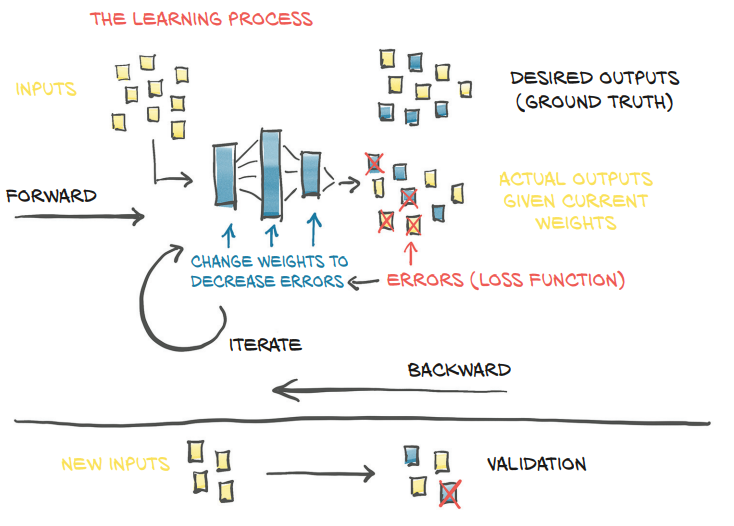

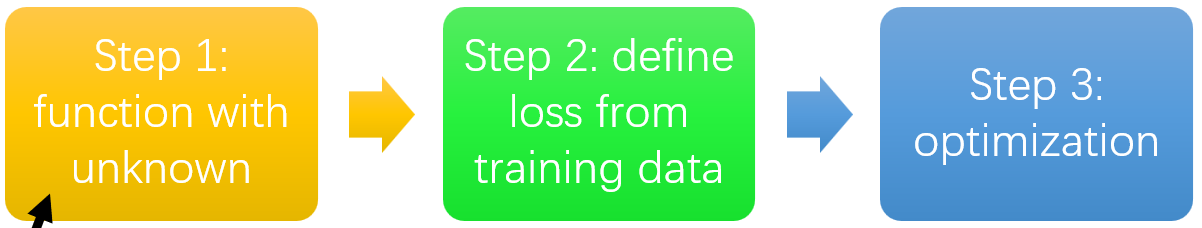


In [36]:
# t_c 摄氏度 t_u华氏温度

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)


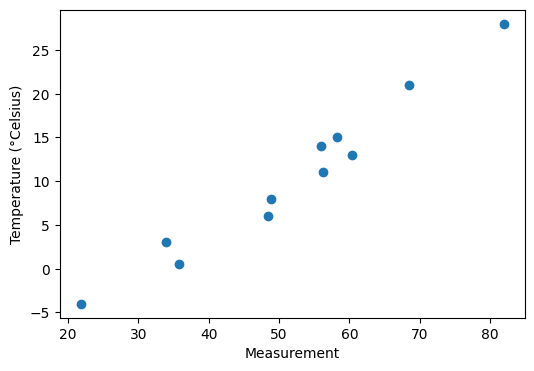

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt

#fig = plt.figure(dpi=300)
plt.figure(figsize=(6, 4)) 
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.show()
plt.savefig("temp_data_plot.png", format="png")

# 1  Choosing a linear model as a first try （选择模型）

In [4]:
## 定义模型，根据先验经验是线性关系
def model(x, w, b):
    return w * x + b

# 2   Less loss is what we want （定义损失）

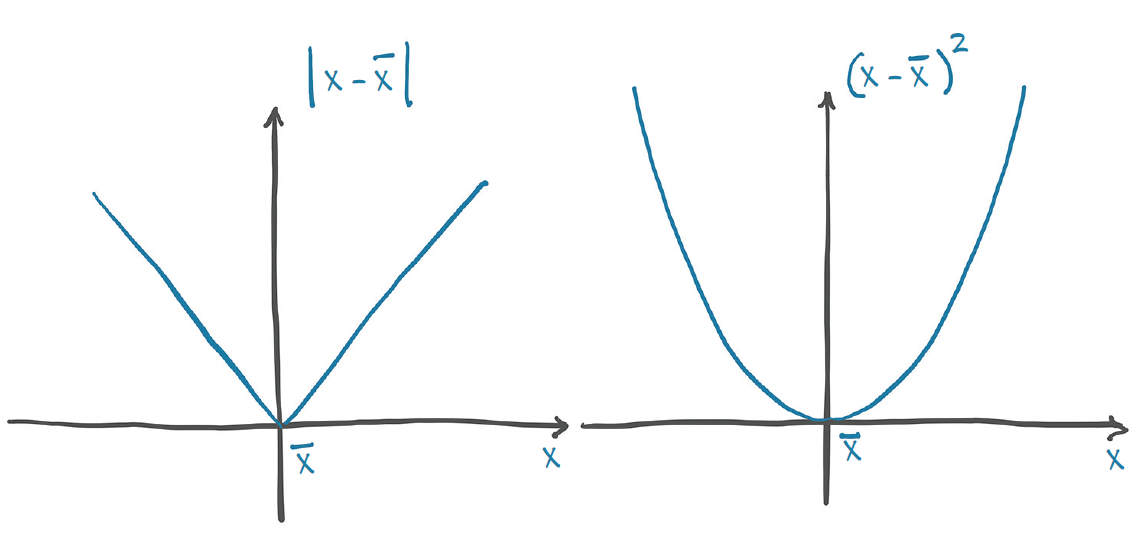


In [5]:
## 定义损失
def loss_fn(y, yl):
    squared_diffs = 0.5*(y - yl)**2
    return squared_diffs.mean()

In [6]:
##  初始化参数，预测结果t_p
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000,
        56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [7]:
loss = loss_fn(t_p, t_c)
loss

tensor(881.9424)

##### 3 Optimization   Down along the gradient梯度下降

In [8]:
### 计算梯度，自己定义计算梯度

delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

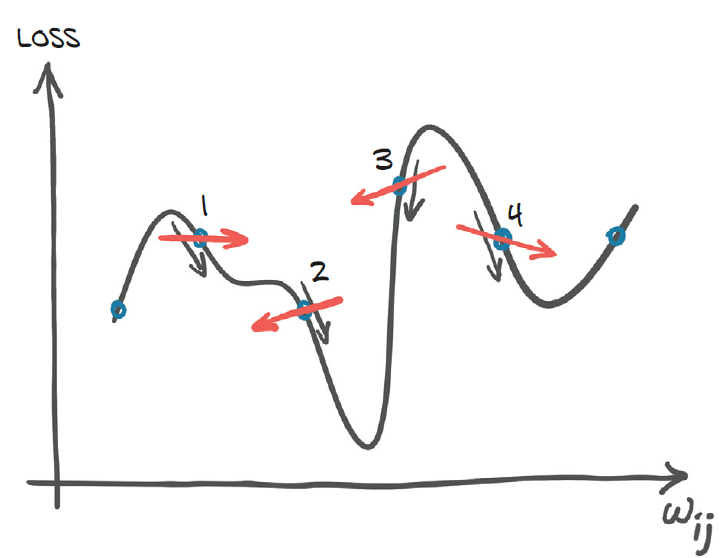

In [9]:
### 定义学习率，迭代梯度算法

learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [10]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

###  计算损失函数的微分

In [11]:
def dloss_fn(y, yl):
    dsq_diffs =  (y - yl) / t_p.size(0)  # t_p.size[0]给出tessor维度数，在这代表损失的平均
    return dsq_diffs

# d x^2/dx=2x

### 将导数应用到模型中
回想我们的线性模型 tp=t_u*w+b

In [12]:
def dmodel_dw(x, w, b):
    return x

In [13]:
def dmodel_db(x, w, b):
    return 1.0

### 定义梯度函数 

In [14]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)   # 定义损失函数
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b) # 关于权重w的梯度
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b) # 关于偏置b的梯度
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  # 返回dl/dw,dl/db的数组形式

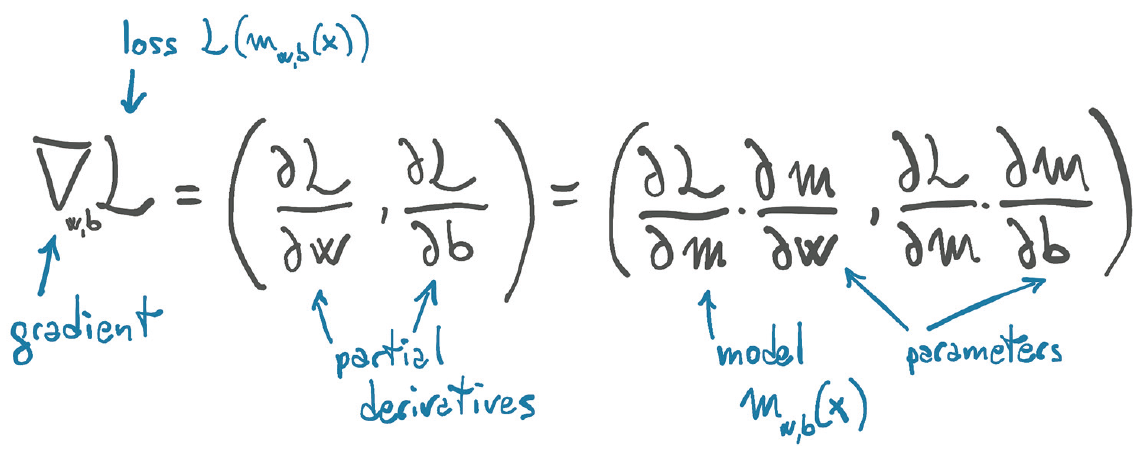

#  3 优化-迭代以适应模型

### 定义循环训练函数 

In [15]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)       # 1 定义模型  
        loss = loss_fn(t_p, t_c)     #  2 定义损失
        grad = grad_fn(t_u, t_c, t_p, w, b)  # 求梯度
        params = params - learning_rate * grad # 更新参数

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params   # 输出参数

### 循环训练

In [16]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 500,4000, 5000,50000,100000,200000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [17]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([-1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 2246.242188
    Params: tensor([35.2295,  0.6230])
    Grad:   tensor([-3622.9480,   -62.3000])
Epoch 2, Loss 1802129.125000
    Params: tensor([-994.2997,  -17.5271])
    Grad:   tensor([102952.9141,   1815.0100])
Epoch 3, Loss 1455264896.000000
    Params: tensor([28261.9473,   497.8004])
    Grad:   tensor([-2925624.7500,   -51532.7539])
...
Epoch 10, Loss 325881670712778284221320921088.000000
    Params: tensor([-4.2292e+14, -7.4496e+12])
    Grad:   tensor([4.3780e+16, 7.7118e+14])
Epoch 11, Loss 263159862183115715117112975425536.000000
    Params: tensor([1.2018e+16, 2.1170e+14])
    Grad:   tensor([-1.2441e+18, -2.1915e+16])
...


tensor([9.7050e+18, 1.7095e+17])

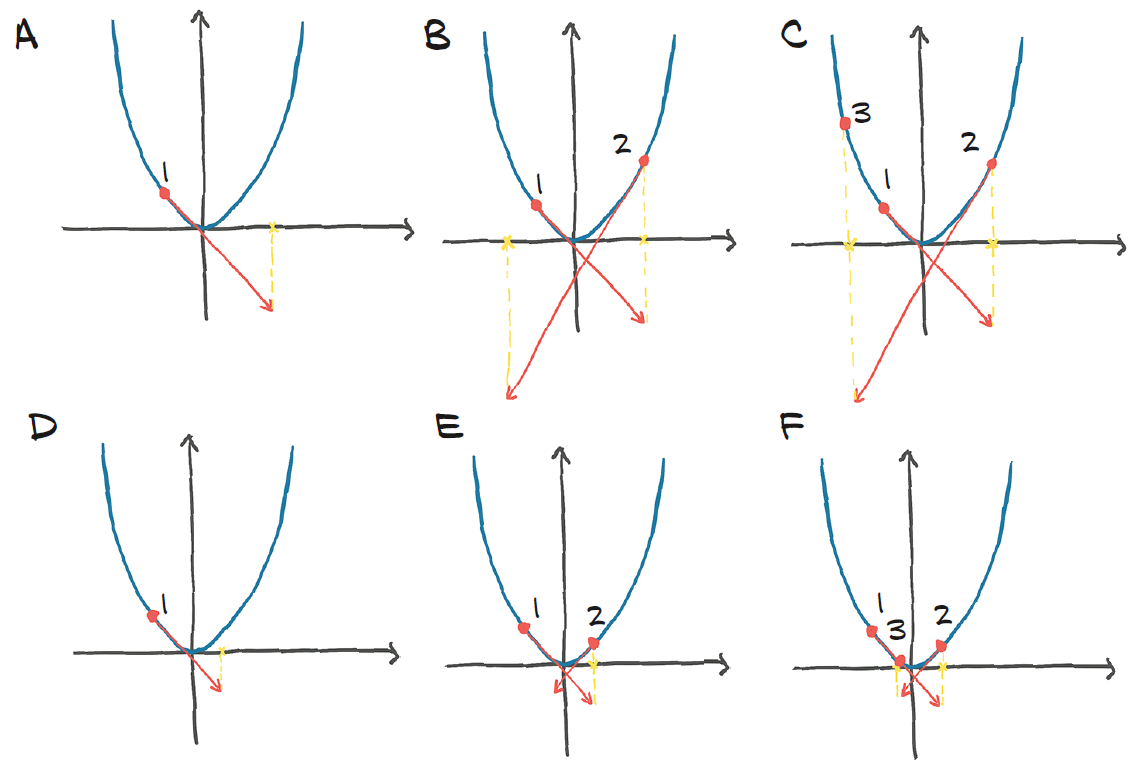

In [18]:
training_loop(
    n_epochs = 200000, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 881.942383
    Params: tensor([ 0.7741, -0.0041])
    Grad:   tensor([2258.6482,   41.3000])
Epoch 2, Loss 446.683105
    Params: tensor([ 0.6147, -0.0071])
    Grad:   tensor([1594.2113,   29.5961])
Epoch 3, Loss 229.839371
    Params: tensor([ 0.5022, -0.0092])
    Grad:   tensor([1125.2327,   21.3351])
...
Epoch 10, Loss 16.194426
    Params: tensor([ 0.2558, -0.0146])
    Grad:   tensor([98.1817,  3.2437])
Epoch 11, Loss 15.371319
    Params: tensor([ 0.2489, -0.0149])
    Grad:   tensor([69.2917,  2.7348])
...
Epoch 99, Loss 14.534201
    Params: tensor([ 0.2325, -0.0285])
    Grad:   tensor([-0.0266,  1.5126])
Epoch 100, Loss 14.533970
    Params: tensor([ 0.2325, -0.0287])
    Grad:   tensor([-0.0266,  1.5126])
...
Epoch 500, Loss 14.442746
    Params: tensor([ 0.2335, -0.0891])
    Grad:   tensor([-0.0266,  1.5073])
Epoch 4000, Loss 13.671179
    Params: tensor([ 0.2427, -0.6086])
    Grad:   tensor([-0.0257,  1.4618])
Epoch 5000, Loss 13.459278
    Params: tensor

tensor([  0.4839, -14.3033])

In [19]:
t_un = 0.1 * t_u

In [20]:
training_loop(
    n_epochs = 4000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, # <1>
    t_c = t_c)

Epoch 1, Loss 40.182171
    Params: tensor([1.3881, 0.0532])
    Grad:   tensor([-38.8070,  -5.3200])
Epoch 2, Loss 27.162054
    Params: tensor([1.6593, 0.0858])
    Grad:   tensor([-27.1191,  -3.2566])
Epoch 3, Loss 20.829231
    Params: tensor([1.8490, 0.1040])
    Grad:   tensor([-18.9752,  -1.8193])
...
Epoch 10, Loss 14.754425
    Params: tensor([2.2630, 0.0702])
    Grad:   tensor([-1.7530,  1.2140])
Epoch 11, Loss 14.712447
    Params: tensor([2.2760, 0.0572])
    Grad:   tensor([-1.3004,  1.2927])
...
Epoch 99, Loss 12.856277
    Params: tensor([ 2.5210, -1.1898])
    Grad:   tensor([-0.2420,  1.3699])
Epoch 100, Loss 12.836930
    Params: tensor([ 2.5234, -1.2035])
    Grad:   tensor([-0.2418,  1.3688])
...
Epoch 500, Loss 7.226823
    Params: tensor([ 3.3430, -5.8432])
    Grad:   tensor([-0.1721,  0.9744])
Epoch 4000, Loss 1.478868
    Params: tensor([  5.2643, -16.7192])
    Grad:   tensor([-0.0088,  0.0498])


tensor([  5.2643, -16.7192])

In [21]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss 40.182171
Epoch 2, Loss 27.162054
Epoch 3, Loss 20.829231
...
Epoch 10, Loss 14.754425
Epoch 11, Loss 14.712447
...
Epoch 99, Loss 12.856277
Epoch 100, Loss 12.836930
...
Epoch 500, Loss 7.226823
Epoch 4000, Loss 1.478868
Epoch 5000, Loss 1.466573


tensor([  5.3235, -17.0544])

<Figure size 640x480 with 0 Axes>

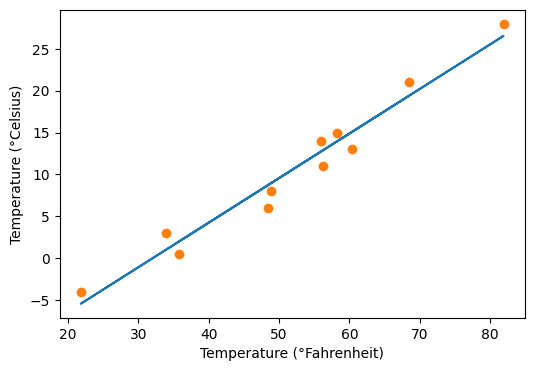

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

#fig = plt.figure(dpi=300)
plt.figure(figsize=(6, 4)) 
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.show()
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

In [23]:
t_un = 0.02 * t_u

In [24]:
params = training_loop(
    n_epochs = 10000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss 80.638344
Epoch 2, Loss 78.214340
Epoch 3, Loss 75.891495
...
Epoch 10, Loss 62.128708
Epoch 11, Loss 60.476151
...
Epoch 99, Loss 22.416498
Epoch 100, Loss 22.361563
...
Epoch 500, Loss 15.101657
Epoch 4000, Loss 1.923581
Epoch 5000, Loss 1.638363


tensor([ 26.6773, -17.1292])

<Figure size 640x480 with 0 Axes>

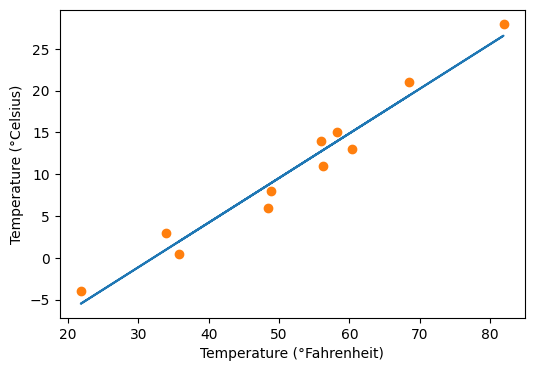

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

#fig = plt.figure(dpi=300)
plt.figure(figsize=(6, 4)) 
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.show()
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

<Figure size 640x480 with 0 Axes>

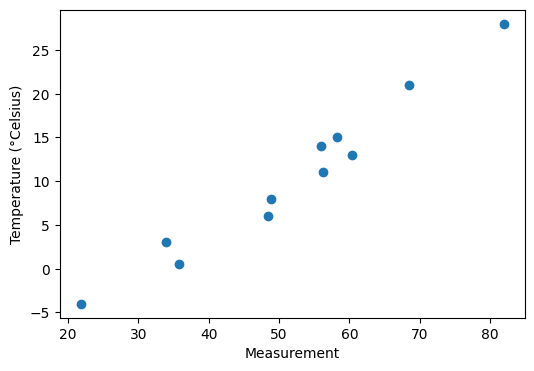

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt

#fig = plt.figure(dpi=600)
plt.figure(figsize=(6, 4)) 
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.show()
plt.savefig("temp_data_plot.png", format="png")

In [27]:
# t_c 摄氏度 t_u华氏温度

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)


<Figure size 640x480 with 0 Axes>

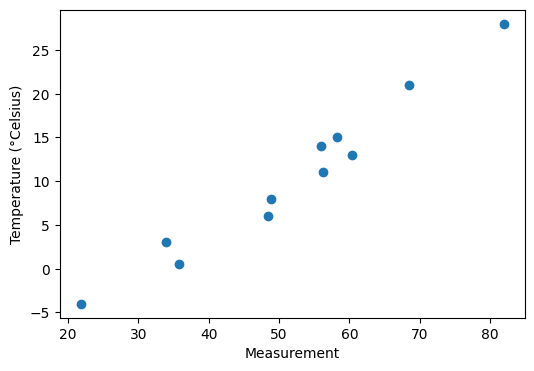

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt

#fig = plt.figure(dpi=300)
plt.figure(figsize=(6, 4)) 
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.show()
plt.savefig("temp_data_plot.png", format="png")

In [29]:
x = np.arange(-100,100,1) # bias
y = np.arange(-10,10,0.1) # weight
Z = np.zeros((len(x),len(y)))
X,Y = np.meshgrid(x, y)
for i in range(len(x)):
    for j in range(len(y)):
        b = x[i]
        w = y[j]
        Z[j][i]=0
        for n in range(len(t_c)):
            Z[j][i] = Z[j][i]+(t_u[n]-b-w*t_c[n])**2
        Z[j][i] = Z[j][i]/len(t_c)

<Figure size 640x480 with 0 Axes>

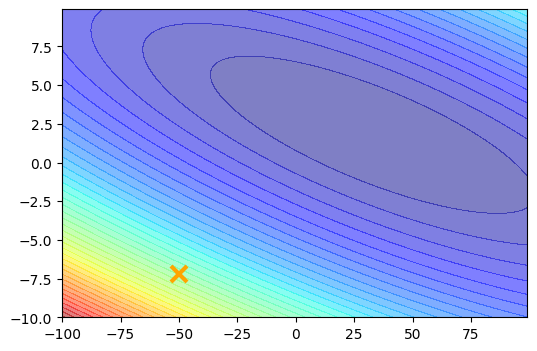

In [30]:
plt.figure(figsize=(6, 4)) 
plt.contourf(x,y,Z,50, alpha=0.5, cmap=plt.get_cmap('jet'))
plt.plot([-50],[-7.2],'x',ms=12,markeredgewidth=3,color='orange')
plt.show()

In [31]:
# t_u=b+w*t_c
b = -60 # initial b
w = -8 # initial w
lr = 0.000001 #learning rate
interation = 100000

# store initial values for plotting.
b_histroy = [b]
w_histroy = [w]

# interations 
for i in range(interation):
   
    b_grad = 0.0
    w_grad = 0.0
    for n in range(len(t_c)):
        b_grad = b_grad - 2.0*(t_u[n]-b-w*t_c[n])*1.0
        w_grad = w_grad - 2.0*(t_u[n]-b-w*t_c[n])*t_c[n]   
    # update parameters
    b = b - lr * b_grad 
    w = w - lr * w_grad
    
    # store parameters for plotting 
    b_histroy.append(b)
    w_histroy.append(w)

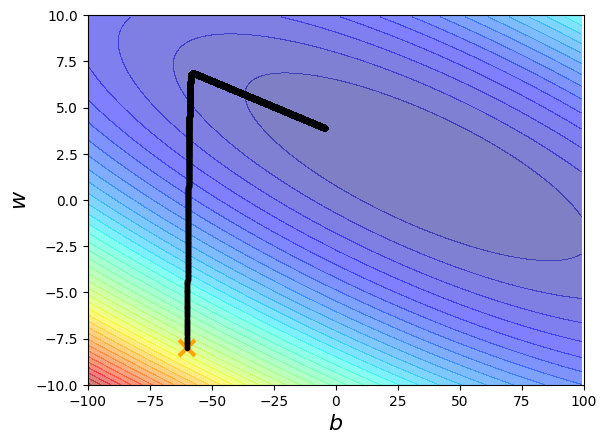

In [32]:
# plot the firgure
plt.contourf(x,y,Z,50, alpha=0.5, cmap=plt.get_cmap('jet'))
plt.plot([-60],[-8],'x',ms=12,markeredgewidth=3,color='orange')
plt.plot( b_histroy,w_histroy,'o-',ms=3,lw=1.5,color='black')
plt.xlim(-100,100)
plt.ylim(-10,10)
plt.xlabel(r'$b$',fontsize=16)
plt.ylabel(r'$w$',fontsize=16)
plt.show()

In [33]:
# t_u=b+w*t_c
b = -60 # initial b
w = -8 # initial w
lr = 0.0001 #learning rate
interation = 50000

# store initial values for plotting.
b_histroy = [b]
w_histroy = [w]

# interations 
for i in range(interation):
   
    b_grad = 0.0
    w_grad = 0.0
    for n in range(len(t_c)):
        b_grad = b_grad - 2.0*(t_u[n]-b-w*t_c[n])*1.0
        w_grad = w_grad - 2.0*(t_u[n]-b-w*t_c[n])*t_c[n]   
    # update parameters
    b = b - lr * b_grad 
    w = w - lr * w_grad
    
    # store parameters for plotting 
    b_histroy.append(b)
    w_histroy.append(w)

KeyboardInterrupt: 

In [ ]:
# plot the firgure
plt.contourf(x,y,Z,50, alpha=0.5, cmap=plt.get_cmap('jet'))
plt.plot([-60],[-8],'x',ms=12,markeredgewidth=3,color='orange')
plt.plot( b_histroy,w_histroy,'o-',ms=3,lw=1.5,color='black')
plt.xlim(-100,100)
plt.ylim(-10,10)
plt.xlabel(r'$b$',fontsize=16)
plt.ylabel(r'$w$',fontsize=16)
plt.show()

In [ ]:
# t_u=b+w*t_c
b = -60 # initial b
w = -8 # initial w
lr = 0.0001 #learning rate
interation = 50000

# store initial values for plotting.
b_histroy = [b]
w_histroy = [w]

# interations 
for i in range(interation):
   
    b_grad = 0.0
    w_grad = 0.0
    for n in range(len(t_c)):
        b_grad = b_grad - 2.0*(t_u[n]-b-w*t_c[n])*1.0
        w_grad = w_grad - 2.0*(t_u[n]-b-w*t_c[n])*t_c[n]*0.02   
    # update parameters
    b = b - lr * b_grad 
    w = w - lr * w_grad
    
    # store parameters for plotting 
    b_histroy.append(b)
    w_histroy.append(w)

In [ ]:
# plot the firgure
plt.contourf(x,y,Z,50, alpha=0.5, cmap=plt.get_cmap('jet'))
plt.plot([-60],[-8],'x',ms=12,markeredgewidth=3,color='orange')
plt.plot( b_histroy,w_histroy,'o-',ms=3,lw=1.5,color='black')
plt.xlim(-100,100)
plt.ylim(-10,10)
plt.xlabel(r'$b$',fontsize=16)
plt.ylabel(r'$w$',fontsize=16)
plt.show()

In [ ]:
# t_u=b+w*t_c
b = -60 # initial b
w = -8 # initial w
lr = 0.0004 #learning rate
interation = 50000

# store initial values for plotting.
b_histroy = [b]
w_histroy = [w]

# interations 
for i in range(interation):
   
    b_grad = 0.0
    w_grad = 0.0
    for n in range(len(t_c)):
        b_grad = b_grad - 2.0*(t_u[n]-b-w*t_c[n])*1.0
        w_grad = w_grad - 2.0*(t_u[n]-b-w*t_c[n])*t_c[n]   
    # update parameters
    b = b - lr * b_grad 
    w = w - lr * w_grad
    
    # store parameters for plotting 
    b_histroy.append(b)
    w_histroy.append(w)

In [ ]:
# plot the firgure
plt.contourf(x,y,Z,50, alpha=0.5, cmap=plt.get_cmap('jet'))
plt.plot([-60],[-8],'x',ms=12,markeredgewidth=3,color='orange')
plt.plot( b_histroy,w_histroy,'o-',ms=3,lw=1.5,color='black')
plt.xlim(-100,100)
plt.ylim(-10,10)
plt.xlabel(r'$b$',fontsize=16)
plt.ylabel(r'$w$',fontsize=16)
plt.show()

In [ ]:
t_u=0.1 * t_u

In [ ]:
# t_u=b+w*t_c
b = -60 # initial b
w = -8 # initial w
lr = 0.0004 #learning rate
interation = 50000

# store initial values for plotting.
b_histroy = [b]
w_histroy = [w]

# interations 
for i in range(interation):
   
    b_grad = 0.0
    w_grad = 0.0
    for n in range(len(t_c)):
        b_grad = b_grad - 2.0*(t_u[n]-b-w*t_c[n])*1.0
        w_grad = w_grad - 2.0*(t_u[n]-b-w*t_c[n])*t_c[n]   
    # update parameters
    b = b - lr * b_grad 
    w = w - lr * w_grad
    
    # store parameters for plotting 
    b_histroy.append(b)
    w_histroy.append(w)

In [ ]:
# plot the firgure
plt.contourf(x,y,Z,50, alpha=0.5, cmap=plt.get_cmap('jet'))
plt.plot([-60],[-8],'x',ms=12,markeredgewidth=3,color='orange')
plt.plot( b_histroy,w_histroy,'o-',ms=3,lw=1.5,color='black')
plt.xlim(-100,100)
plt.ylim(-10,10)
plt.xlabel(r'$b$',fontsize=16)
plt.ylabel(r'$w$',fontsize=16)
plt.show()